In [27]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import integrate

from high_correlation import High2Corr
from reconstructor import recon_sp
from measure import gp_correlation_dim, nearest_neighbours, Stau
from observability import observability, plot_obs
from orbit_diagram import orbit_diagram, plot_orbit_diagram
from poincare_section import poincare_section, plot_poincare_section
from power_series_inversion import nonlinear_inversion
from universal_map import universal_map, plot_universal_map

# This script contains several demonstrators on how to perform nonlinear time series analysis.

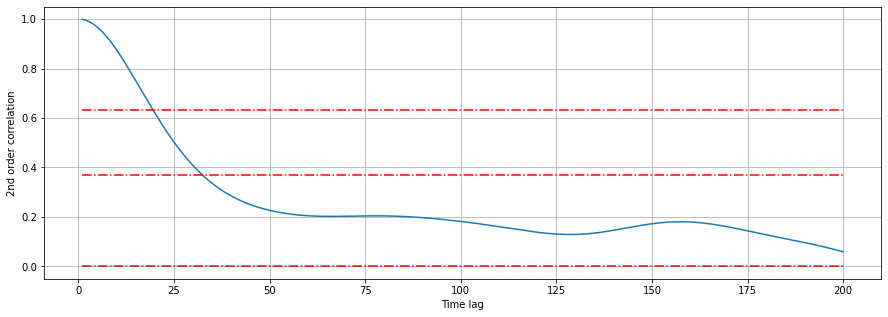

In [16]:
# --------------------HIGHER ORDER CORRELATION--------------------
# This section shows how to use the functions in high_correlation.py to calculate higher order correlations
    
def lorenz_system(x, t, rho, sigma, beta):
    xdot = np.zeros(len(x))
    xdot[0] = sigma * (x[1] - x[0])
    xdot[1] = x[0] * (rho - x[2]) - x[1]
    xdot[2] = x[1] * x[0] - beta * x[2]
    return xdot
    
t = np.arange(0, 100, 0.01)
x0 = np.array([0, 1.02, 0])
v = integrate.odeint(lorenz_system, x0, t, args = (28, 10, 8/3,))
t = t[int(len(v)*0.5):]
v = v[int(len(v)*0.5):]
    
T = np.arange(1, 200+1, 1)
C2 = np.zeros(len(T))
for i in range(len(T)):
    C2[i] = High2Corr(T[i], v[:, 0])
    
plt.figure(figsize = (15, 5))
plt.plot(T, C2)
plt.grid(True)
plt.plot(T, T * 0 + 1 / np.exp(1), 'r-.')
plt.plot(T, T * 0 + 1 - 1 / np.exp(1), 'r-.')
plt.plot(T, T * 0,'r-.')
plt.xlabel("Time lag")
plt.ylabel("2nd order correlation")
plt.show()

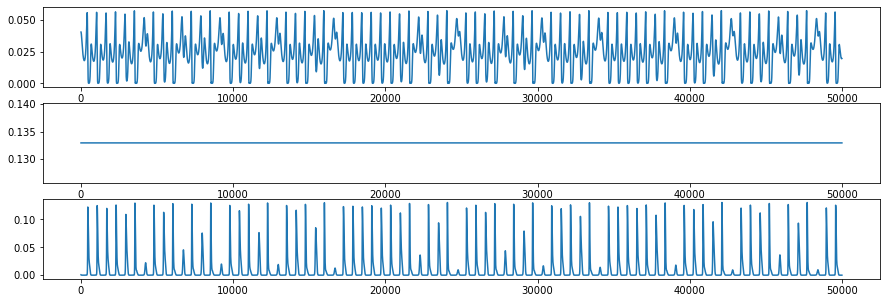

In [19]:
# --------------------OBSERVABILITY--------------------
# This section shows how to calculate an ODE's observability for each variable. 
# Note that different variables might have different observabilities.

def xdot_fun(x, t, a, b, c):
    xdot = np.zeros(len(x))
    xdot[0] = -x[1] - x[2] # x
    xdot[1] = x[0] + a * x[1] # y
    xdot[2] = b + x[2] * (x[0] - c) # z
    return xdot

a = 0.398
b = 2.0
c = 4.0
dt = 0.01
t = np.arange(0, 2000, dt)
x0 = np.array([-1.0, 0, 0])
v = integrate.odeint(xdot_fun, x0, t, args = (a, b, c))
[n, m] = np.shape(v)
x = v[int(n/2):, 0]
y = v[int(n/2):, 1]
z = v[int(n/2):, 2]
    
J = []
for i in range(len(x)):
    J.append(np.array([[0, -1, -1], [1, a, 0], [z[i], 0, x[i] - c]]))
    
dx, dy, dz = observability(x, y, z, J)
plot_obs(dx, dy, dz)

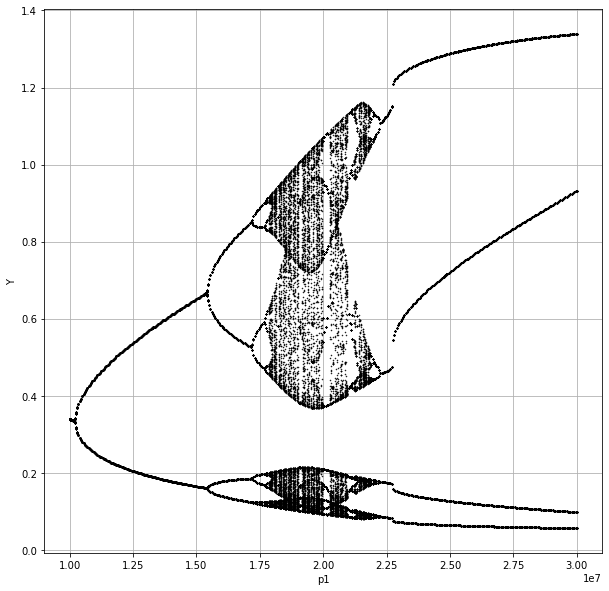

In [22]:
# --------------------ORBIT DIAGRAM--------------------
# This section demonstrates how to create an orbit diagram.

def xdot_fun(x, t, p1):
    k = 600*10**6
    M = (3*10**5) * 0
    rho = 2500
    eta = 50
    p2 = 0.1*10**6 
    h0 = 1
    L = 10
    A = (10**7)*1
    xdot = np.zeros(len(x))
    effectm = M+rho*L**3/12/x[1]
    damping = A+L**3/12/x[1]*(12*eta/x[1]**2-rho/2*x[2]/x[1])
    kcoeff = k*(x[1]-h0)
    Lcoeff = L*(p1+p2)/2-L*rho*x[0]**2/2
    xdot[0] = (p1-p2)/(rho*L)-(12*eta*x[0])/(rho*x[1]**2)
    xdot[1] = x[2]    
    xdot[2] = (Lcoeff-kcoeff-damping*x[2])/effectm
    return xdot

# range of parameter values to vary:
dR = 10**5 / 2
R = np.arange(10*10**6, 30*10**6 + dR, dR)
# time steps to try:
t = np.arange(0, 50, 0.001)
# initial conditions:
x0 = np.array([0, 1.02, 0])

X, Y, Z = orbit_diagram(xdot_fun, x0, t, R)
plot_orbit_diagram(R, Y, "p1", "Y")

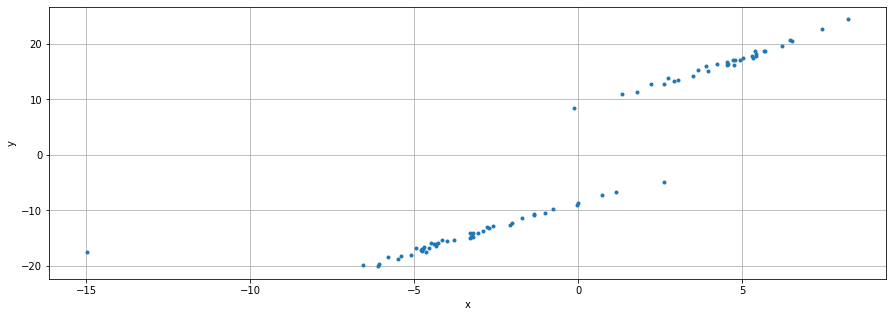

In [24]:
# --------------------POINCARE SECTION--------------------
# This section demonstrates how to create a Poincare section.

def xdot_fun(x, t, rho, sigma, beta):
    xdot = np.zeros(len(x))
    xdot[0] = sigma * (x[1] - x[0])
    xdot[1] = x[0] * (rho - x[2]) - x[1]
    xdot[2] = x[0] * x[1] - beta * x[2]
    return xdot

a = 28.0
b = 10.0
c = 8.0 / 3.0
dt = 0.01
t = np.arange(0, 200, dt)
x0 = np.array([1.0, 0, 0])
v = integrate.odeint(xdot_fun, x0, t, args = (a, b, c))
[n, m] = np.shape(v)
x = v[int(n*0.7):, 0]
y = v[int(n*0.7):, 1]
z = v[int(n*0.7):, 2]

x_s, y_s = poincare_section(x, y, z, 25)
plot_poincare_section(x_s, y_s)

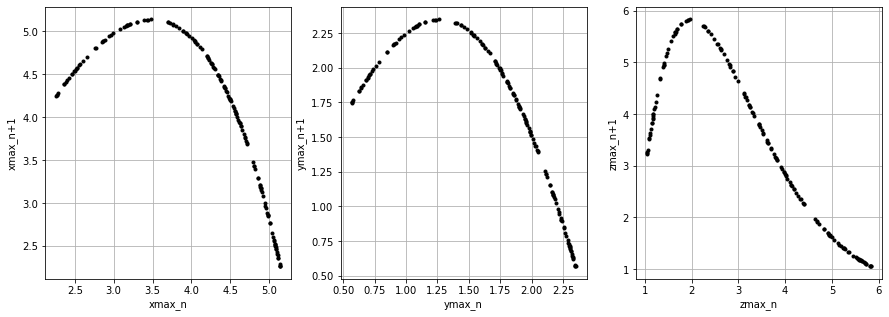

In [26]:
# --------------------UNIVERSAL MAP--------------------
# This section shows how to create an ODE's universal map.

def xdot_fun(x, t, a, b, c):
    xdot = np.zeros(len(x))
    xdot[0] = -x[1] - x[2] # x
    xdot[1] = x[0] + a * x[1] # y
    xdot[2] = b + x[2] * (x[0] - c) # z
    return xdot

a = 0.398
b = 2.0
c = 4.0
dt = 0.01
t = np.arange(0, 2000, dt)
x0 = np.array([-1.0, 0, 0])
v = integrate.odeint(xdot_fun, x0, t, args = (a, b, c))
[n, m] = np.shape(v)
x = v[int(n/2):, 0]
y = v[int(n/2):, 1]
z = v[int(n/2):, 2]

X0, Y0, Z0 = universal_map(x, y, z)
plot_universal_map(X0, Y0, Z0)

Estimated nonlinear ODE parameters:
[[ 0.          0.          0.        ]
 [-9.99986947 27.99767225  0.        ]
 [ 9.99986948 -0.99945893  0.        ]
 [ 0.          0.         -2.66660223]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99997582]
 [ 0.         -0.99993892  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


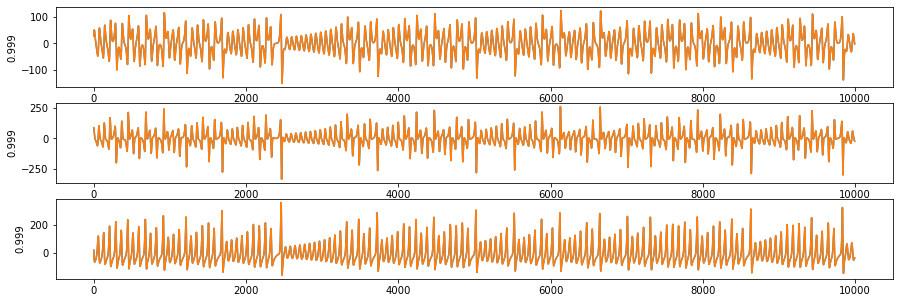

In [29]:
# --------------------POWER SERIES INVERSION--------------------
# This section shows how to perform power series inversion of a nonlinear system.

# Create nonlinear signal to be inverted for the model parameters
def lorenz_attractor(x, t, s = 10, B = 8.0 / 3.0, r = 28):
    V = np.zeros(len(x))
    V[0] = s * (x[1] - x[0])
    V[1] = r * x[0] - x[1] - x[0] * x[2]
    V[2] = x[0] * x[1] - B * x[2]
    return V

dt = 0.01
t = np.arange(0, 1000, dt)
x0 = np.array([1, 2, 3])
a = integrate.odeint(lorenz_attractor, x0, t)
a = a[-int(len(a) / 10):]
    
# Perform the nonlinear signal inversion for the ODE parameters!
D, G, m, P = nonlinear_inversion(a, dt, 2)
print("Estimated nonlinear ODE parameters:")
print(m)
    
# Plot the predictions vs the actual data:
PX = P[:, 0]
PY = P[:, 1]   
PZ = P[:, 2]
dx = D[:,0] 
dy = D[:,1]
dz = D[:,2]
    
plt.figure(figsize = (15, 5))    
plt.subplot(3, 1, 1)
plt.plot(dx)
plt.plot(PX)
plt.ylabel(str(np.corrcoef(dx, PX)[0, 1])[:5])
plt.subplot(3, 1, 2)
plt.plot(dy)
plt.plot(PY)
plt.ylabel(str(np.corrcoef(dy, PY)[0, 1])[:5])
plt.subplot(3, 1, 3)
plt.plot(dz)
plt.plot(PZ)
plt.ylabel(str(np.corrcoef(dz, PZ)[0, 1])[:5])
plt.show()

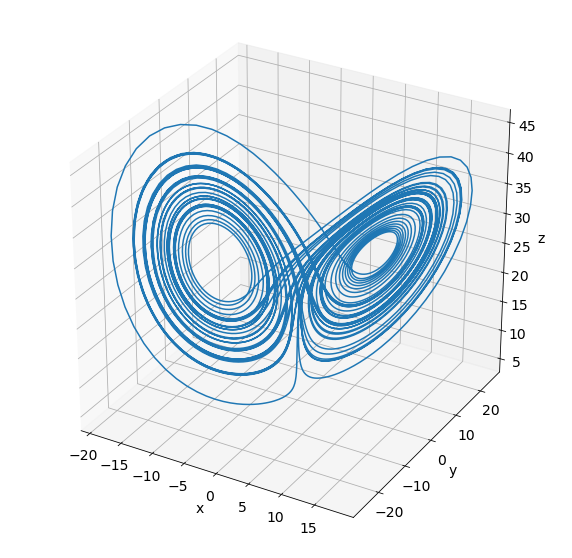

In [2]:
# --------------------CORRELATION DIMENSION--------------------
# Now let's take a look at how to measure the correlation dimension of a time series.
# We will measure the correlation dimension of the Lorenz attractor for rho = 28, sigma = 10
# and beta = 8/3. The measured correlation dimension should be about 2.05.

def get_range(x):
    return np.max(np.abs(x)) - np.min(np.abs(x))
    
def lorenz_system(x, t, rho, sigma, beta):
    xdot = np.zeros(len(x))
    xdot[0] = sigma * (x[1] - x[0])
    xdot[1] = x[0] * (rho - x[2]) - x[1]
    xdot[2] = x[1] * x[0] - beta * x[2]
    return xdot
    
t = np.arange(0, 100, 0.01)
x0 = np.array([0, 1.02, 0])
v = integrate.odeint(lorenz_system, x0, t, args = (28, 10, 8/3,))
t = t[int(len(v)*0.5):]
v = v[int(len(v)*0.5):]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(v[:,0], v[:, 1], v[:,2])
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
ax.set_zlabel("z", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.zaxis.set_tick_params(labelsize = 14)
plt.show()

In [3]:
r_min = np.min([get_range(v[:,0]), get_range(v[:,1]), get_range(v[:,2])]) / 1000
r_max = np.max([get_range(v[:,0]), get_range(v[:,1]), get_range(v[:,2])]) / 10
N_r = 1000
print("{:.3f}, {:.3f}, {}".format(r_min, r_max, N_r))

recsp = v[-5000:]
print(recsp.shape)

0.019, 4.266, 1000
(5000, 3)


In [4]:
start_time = time.time()

r, C = gp_correlation_dim(recsp, r_min, r_max, N_r)

print("Time elapsed: {:.3f} s".format(time.time() - start_time))

Time elapsed: 180.354 s


Estimated correlation dimension: 2.065


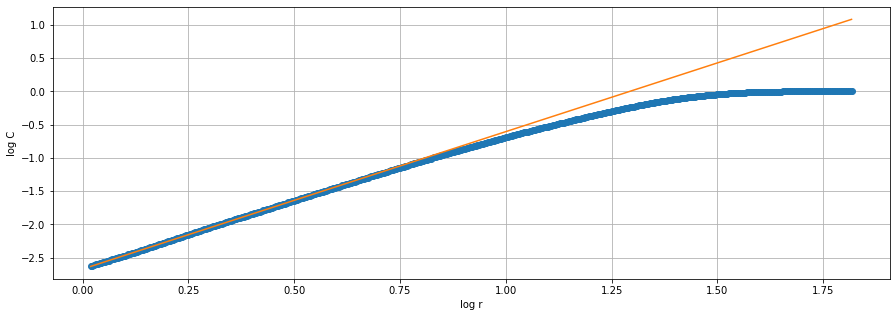

In [5]:
# Our estimated correlation dimension is 2.065 which is very close to the accepted value of 2.05.
want = r <= 0.5
m = np.polyfit(r[want], C[want], 1)

print("Estimated correlation dimension: {:.3f}".format(m[0]))

plt.figure(figsize = (15, 5))
plt.plot(r, C, "-o")
plt.plot(r, r * m[0] + m[1])
plt.grid(True)
plt.xlabel("log r")
plt.ylabel("log C")
plt.show()

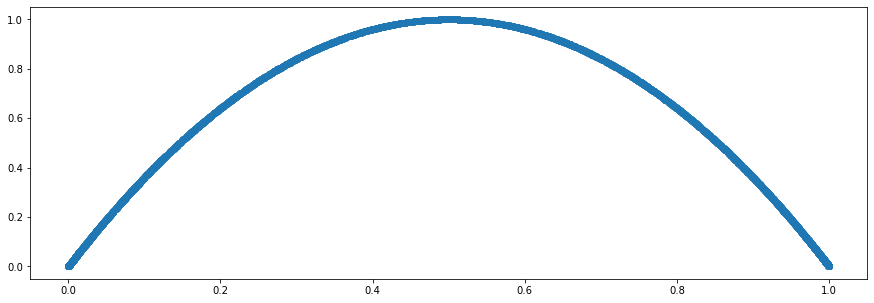

In [6]:
# --------------------LYAPUNOV EXPONENT--------------------
# Next, let's look at how to measure the Lyapunov exponent of a time series. 
# This time round, we will use the Logistic map attractor. 
# The Lyapunov exponent should be about 0.68.
    
def logistic_map_attractor(N = 5000, A = 4, data_0 = np.pi / 10.0):
    data = np.zeros(N)
    data[0] = data_0
    
    for i in range(N - 1):
        data[i + 1] = A * data[i] * (1 - data[i])    
        
    return data    

# create logistic map attractor data
data = logistic_map_attractor(N = 5000, A = 4, data_0 = np.pi / 10.0)
data = data[1000:]

# time delayed reconstruction
recsp = recon_sp(tauI = 1, dm = 3, data = data) 
# columns correspond to dimensions,
# rows correspond to time, so each row is a state vector with respect to t

plt.figure(figsize = (15, 5))
plt.plot(recsp[:, 0], recsp[:, 1], "o")
plt.show()

In [7]:
[nmax, dd] = np.shape(recsp)

start_time = time.time()

print("Calculating Nearest Neighbors...")
EPNb = nearest_neighbours(recsp, tauS = 1, tauL = 20, eps_tol = 0.001, nst = 0, ned = 999, theiler_window = 0)

print("Calculating S...")
x, y = Stau(recsp, EPNb, tauS = 1, tauL = 20, nst = 0, ned = 999)

print("Time taken for computation: {:.3f} s".format(time.time() - start_time))

Calculating Nearest Neighbors...
Calculating S...
    Total points used: 826
    Points without nearest neighbours: 174
Time taken for computation: 67.222 s


Estimated maximal Lyapunov exponent: 0.685


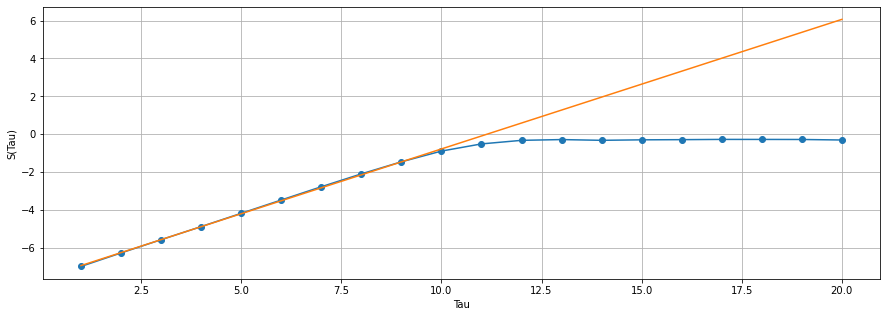

In [8]:
# The measured Lyapunov exponent is 0.685 which is very close to the accepted value!
m = np.polyfit(x[0: 10], y[0: 10], 1)
print("Estimated maximal Lyapunov exponent: {:.3f}".format(m[0]))

plt.figure(figsize=(15, 5))
plt.plot(x, y, '-o')
plt.plot(x, x * m[0] + m[1])
plt.xlabel('Tau')
plt.ylabel('S(Tau)')
plt.grid('on')
plt.show()